In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline
import geopandas as gpd
import xarray as xr
import matplotlib.dates as mdates

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data

from oggm.utils import (floatyear_to_date, date_to_floatyear)

In [2]:
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='W5E5_quality', reset=True)

cfg.PATHS['working_dir'] = working_dir
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match'

2022-12-01 17:11:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-12-01 17:11:06: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-12-01 17:11:06: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-12-01 17:11:06: oggm.utils: Checking the download verification file checksum...
2022-12-01 17:11:07: oggm.cfg: Multiprocessing switched ON after user settings.


In [7]:
# Leh glacier
rgi_id = 'RGI60-14.12678'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]
gdir

2022-12-01 17:11:14: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2022-12-01 17:11:14: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-14.12678
  Region: 14: South Asia West
  Subregion: 14-02: Karakoram                       
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.552 km2
  Lon, Lat: (77.552342005, 34.288076476)
  Grid (nx, ny): (200, 220)
  Grid (dx, dy): (20.0, -20.0)

In [18]:
import os
print(os.listdir(gdir.dir))
with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
    print(ds.temp.head())

['outlines.tar.gz', 'model_run_historical.nc', 'model_flowlines.pkl', 'model_diagnostics_historical.nc', 'log.txt', 'local_mustar.json', 'glacier_grid.json', 'diagnostics.json', 'climate_info.json', 'climate_historical.nc']
<xarray.DataArray 'temp' (time: 5)>
[5 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1901-10-01 1901-11-01 ... 1902-02-01
Attributes:
    units:      degC
    long_name:  2m temperature at height ref_hgt


In [4]:
# "Downscale" the climate data
from oggm.shop import gcm_climate
cfg.PARAMS['store_model_geometry'] = True
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
#for rcp in ['rcp26']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    workflow.execute_entity_task(gcm_climate.process_cmip_data, [gdir],
                                 # Name file to recognize it later
                                 filesuffix='_CCSM4_{}'.format(rcp),  
                                 # temperature projections
                                 fpath_temp=ft,
                                 # precip projections
                                 fpath_precip=fp,
                                 );

2022-12-01 17:11:08: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2022-12-01 17:11:08: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_rcp26_r1i1p1_g025.nc verified successfully.
2022-12-01 17:11:08: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_rcp26_r1i1p1_g025.nc verified successfully.
2022-12-01 17:11:08: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2022-12-01 17:11:08: oggm.shop.gcm_climate: (RGI60-14.12678) process_cmip_data_CCSM4_rcp26
2022-12-01 17:11:09: oggm.shop.gcm_climate: (RGI60-14.12678) process_gcm_data_CCSM4_rcp26
2022-12-01 17:11:09: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_rcp45_r1i1p1_g025.nc verified successfully.
2022-12-01 17:11:09: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.

In [5]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
#for rcp in ['rcp26']:
    rid = '_CCSM4_{}'.format(rcp)
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, ys=2020,
                         # use gcm_data, not climate_historical
                         climate_filename='gcm_data',
                         # use the chosen scenario
                         climate_input_filesuffix=rid,
                         # this is important! Start from 2020 glacier
                         init_model_filesuffix='_historical',
                         # recognize the run for later
                         output_filesuffix=rid,
                         # add monthly diagnostics
                         store_monthly_hydro=True,
                        );

2022-12-01 17:11:11: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp26
2022-12-01 17:11:11: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp26
2022-12-01 17:11:11: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp26
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp45
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp45
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp45
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp60
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp60
2022-12-01 17:11:12: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp60
2022-12-01 17:11:13: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp85
2022-12-01 17:11:13: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp85
2022-12-01 17:11:13: oggm

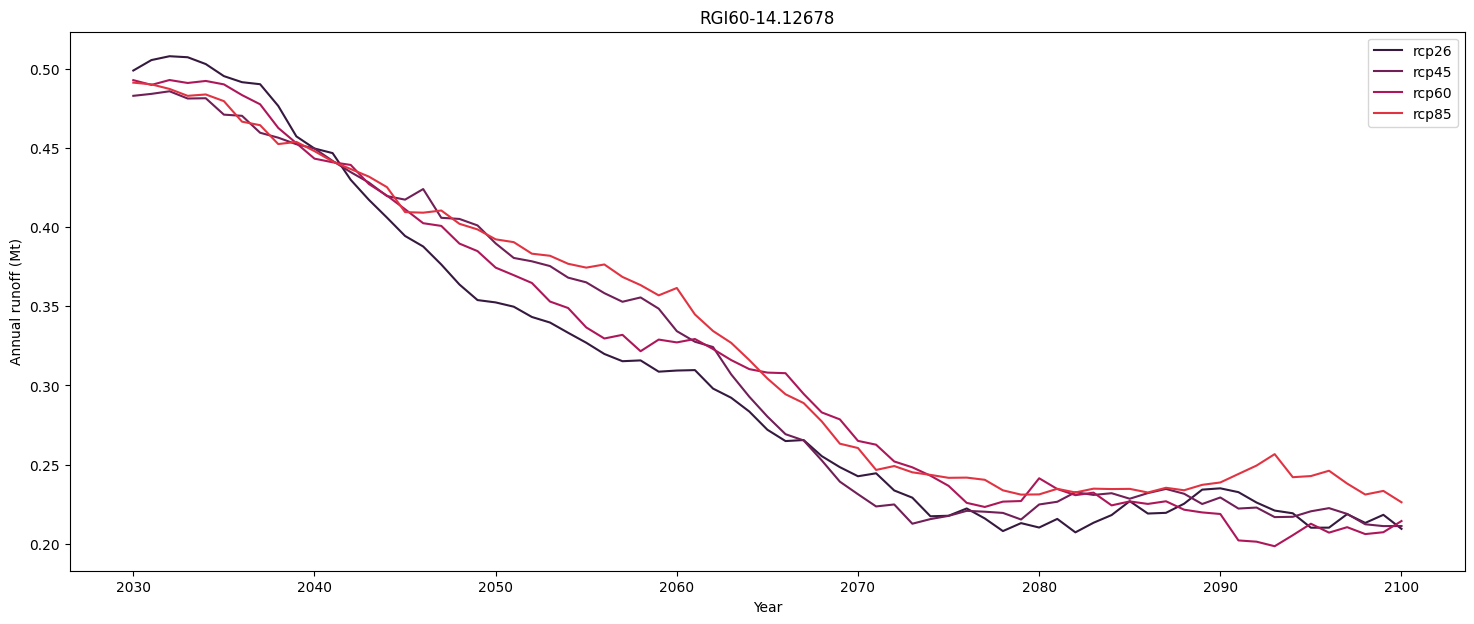

In [6]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7))
# Loop all scenarios
for i, rcp in enumerate(['rcp26', 'rcp45', 'rcp60', 'rcp85']):
    file_id = f'_CCSM4_{rcp}'
    # Open the corresponding data in a context manager.
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                           filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
                   'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean
    # and plot it.
    df_runoff.sum(axis=1).rolling(window=11).mean().plot(ax=ax, label=rcp,
                                  color=sns.color_palette("rocket")[i]
                                  )
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(rgi_id)
plt.legend()
plt.savefig(
        "../figs/Leh_peak_water.png",
        bbox_inches="tight",
        dpi=300,
)